In [5]:
import numpy as np
import shapely
import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
import seaborn as sns


def justify(a, invalid_val=np.nan, axis=1, side='right'):
    """
    Justifies a 2D array
    Courtesy: https://stackoverflow.com/questions/44558215/python-justifying-numpy-array/44559180#44559180

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """
    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val)
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

def layers(var, depth, ax=None, colormap='viridis', plot_soil=True,
           plot_snow=True, variable_range=None, add_colorbar=True,
           line_kwargs={}, cbar_kwargs={}):
    """
    Makes a layers plot. Example usage:

    ::

        import pysumma.plotting as psp
        time_range = slice('10-29-2000', '04-30-2001')
        depth    = ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
        temp     = ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
        psp.layers(temp, depth)

    Parameters
    ----------
    var: xr.DataArray
        The variable holding the data to plot.
        Typically begins with ``mLayer``.
    depth: xr.DataArray
        The variable defining the depths of the interfaces
        of each layer. Typically should be ``iLayerHeight``
    ax: Axes
        The axis to plot on. If none is given, a new axis
        will be created
    colormap: string, default='viridis'
        The colormap to use
    plot_soil: boolean, default=True
        Whether to plot the soil domain
    plot_snow: boolean, default=True
        Whether to plot the snow domain
    variable_range: List[float], default=variable range
        The range of numerical values to use. Must be two numbers.
    add_colorbar: boolean, default=True
        Whether to add a colorbar
    line_kwargs: Dict, default={}
        Keyword arguments to pass to ax.vlines.
        These draw the individual layers.
    cbar_kwargs: Dict, default={}
        Keyword arguments to draw the colorbar.
        They are passed directly to plt.colorbar.
    """
    # Preprocess the data
    vmask = var != -9999
    dmask = depth != -9999
    depth.values = justify(depth.where(dmask).values)
    var.values = justify(var.where(vmask).values)
    lo_depth = depth.where(depth > 0).T
    hi_depth = depth.where(depth < 0).T
    if plot_soil and not plot_snow:
        var = var.where((depth > 0).values[:,:-1]).T
    elif plot_snow and not plot_soil:
        var = var.where((depth < 0).values[:,:-1]).T
    else:
        var = var.T
    time = depth.time.values

    # Map colors to full range of data
    if variable_range is not None:
        assert len(variable_range) == 2, 'variable_range must have 2 values!'
        norm = plt.Normalize(variable_range[0], variable_range[1])
    else:
        norm = plt.Normalize(np.nanmin(var), np.nanmax(var))
    cmap = mpl.cm.get_cmap(colormap)
    rgba = cmap(norm(var))

    # Create axes if needed
    if not ax:
        fig, ax = plt.subplots(figsize=(18,8))

    # Plot soil layers - need to reverse because we plot bottom down
    if plot_soil:
        for l in lo_depth.ifcToto.values[:-1][::-1]:
            y = lo_depth[l]
            y[np.isnan(y)] = 0
            ax.vlines(time, ymin=-y, ymax=0, color=rgba[l], **line_kwargs)

    # Plot snow layers - plot top down
    if plot_snow:
        for l in hi_depth.ifcToto.values[:-1]:
            y = hi_depth[l]
            y[np.isnan(y)] = 0
            if (y != 0).any():
                ax.vlines(time, ymin=0, ymax=-y, color=rgba[l], **line_kwargs)

    # Add the colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(var.values.flatten())
    try:
        label = var.long_name
    except:
        label = var.name
    if 'label' not in cbar_kwargs.keys():
        cbar_kwargs['label'] = label
    if 'ax' not in cbar_kwargs.keys():
        cbar_kwargs['ax'] = ax
    if add_colorbar:
        plt.gcf().colorbar(mappable, **cbar_kwargs)
    return ax, mappable

In [6]:
summa = xr.open_dataset('/home/cdalden/summa_setup/model/output/output_harts_current_WY24_timestep.nc')

In [1]:
depth = summa.isel(hru=0)['iLayerHeight']
var = summa.isel(hru=0)['mLayerVolFracWat']
temp = summa.isel(hru=0)['mLayerTemp']
vmask = var != -9999
dmask = depth != -9999
tmask = temp != -9999
depth.values = justify(depth.where(dmask).values)
var.values = justify(var.where(vmask).values)
temp.values = justify(temp.where(tmask).values)


# Filter out layers where var < 0.2
# var = var.where(var >= 0.2)

# Filter for only where there is snow
total_depth = summa.scalarSnowDepth.isel(hru=0)
total_depth_broadcasted = total_depth.broadcast_like(var)
var = var.where(total_depth_broadcasted > 0.01)

# Calculate the average at all layers
average_temp = temp.mean(dim='midToto')

# Filter var where the average is less than 273.15
filtered_var = var.where(average_temp < 273)

# Calculate the vertical derivative
derivative = filtered_var.diff(dim='midToto')

# Initialize the list to store counts
counts = []

# Loop over the 'time' dimension
for t in var.time.values:
    # Select the derivative for the current timestep
    derivative_t = derivative.sel(time=t)

    # Calculate the running average over 3 layers
    running_avg = derivative_t.rolling(midToto=3, center=False).sum()

    # Filter values that are greater than or equal to 0.2 or less than or equal to -0.2
    threshold = 0.15
    filtered = running_avg.where((running_avg >= threshold) | (running_avg <= -threshold))

    # Count the number of layers with at least one such value
    count = np.isfinite(filtered).sum().values

    # Append the count to the list
    counts.append(count)

# Convert the list to a numpy array
counts = np.array(counts)

crust_days = counts.sum() / 24
mean_crusts = counts.mean()
# binary crust metric
crusts_binary = np.where(counts > 0, 1, 0)

print(f"Crust Days: {crust_days}")
print(f"Mean Crusts: {mean_crusts}")
print(f"Crusts Binary: {crusts_binary.sum()/24}")

NameError: name 'summa' is not defined

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(var.time.values, crusts_binary)


# Convert var.time.values to pandas DatetimeIndex
time_index = pd.DatetimeIndex(var.time.values)

# Filter the dates between November 1 and April 1
filtered_time = time_index[(time_index.month >= 11) | (time_index.month <= 4)]

# Use the filtered_time for xlim
plt.xlim(filtered_time[0], filtered_time[-1])

NameError: name 'plt' is not defined

#### Create table to compare to JS pits

In [9]:
df = pd.DataFrame({
    'crusts_binary': crusts_binary
}, index=var.time.values)

# Resample to daily data
df_daily = df.resample('D').max()

# Now df_daily is a DataFrame with daily data where the day gets a 1 if any hour was a 1 and a 0 if no hours were >0

# df_daily

In [10]:
# Set the maximum number of rows to display to None, which means display all rows
pd.set_option('display.max_rows', None)



### Read in JS obs to compare

In [ ]:
# Add a new column 'new_column' to the DataFrame
wsdot['crust_binary'] = wsdot['Strat'].str.contains('K|P').astype(int)
# wsdot['crust_binary'] = wsdot['Strat'].str.contains('K').astype(int)


# Convert the 'Date' column to datetime
wsdot['Date'] = pd.to_datetime(wsdot['Date'])

# Set the 'Date' column as the index
wsdot.set_index('Date', inplace=True)

### Create confusion matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
# Group by 'Date' and take the maximum 'crust_binary' for each date
wsdot_binary = wsdot.groupby('Date')['crust_binary'].max()

# Add 'obs_crusts_binary' to 'df_daily'
df_daily['obs_crusts_binary'] = wsdot_binary

In [ ]:
# Fill NaN values with 0
df_daily['obs_crusts_binary'].fillna(0, inplace=True)

# Convert 'obs_crusts_binary' to integer
df_daily['obs_crusts_binary'] = df_daily['obs_crusts_binary'].astype(int)

/tmp/ipykernel_26926/1711590603.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_daily['obs_crusts_binary'].fillna(0, inplace=True)


In [ ]:
# Filter 'df_daily' to between December 1, 2023 and March 31, 2024
df_daily_short = df_daily[(df_daily.index >= '2017-12-01') & (df_daily.index <= '2018-03-31')]

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(df_daily_short['crusts_binary'], df_daily_short['obs_crusts_binary'])
print(cf_matrix)

[[ 9 50]
 [13 49]]


### Plot with seaborn

In [ ]:
# # Create the heatmap
# ax = sns.heatmap(cf_matrix, annot=True, fmt='d')

# # Label each quadrant
# ax.text(0.5, 1.5, "Label 1", horizontalalignment='center', verticalalignment='center')
# ax.text(1.5, 1.5, "Label 2", horizontalalignment='center', verticalalignment='center')
# ax.text(0.5, 0.5, "Label 3", horizontalalignment='center', verticalalignment='center')
# ax.text(1.5, 0.5, "Label 4", horizontalalignment='center', verticalalignment='center')

# # Label the ticks
# ax.set_xticklabels(['Obs Miss', 'Obs Hit'])
# ax.set_yticklabels(['SUMMA Miss', 'SUMMA'])

# plt.show()

Text(0.5, 1.0, 'Confusion Matrix for SUMMA vs. WSDOT crusts\nDecember 1, 2017 - March 31, 2018\nthreshold=0.05')

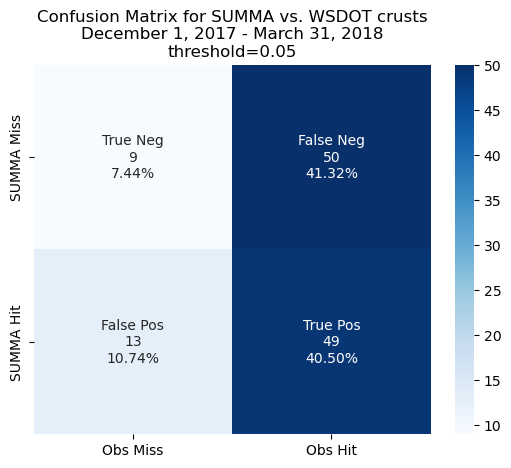

In [ ]:
group_names = ['True Neg','False Neg','False Pos','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Label the ticks
ax.set_xticklabels(['Obs Miss', 'Obs Hit'])
ax.set_yticklabels(['SUMMA Miss', 'SUMMA Hit'])

ax.set_title(f'Confusion Matrix for SUMMA vs. WSDOT crusts\nDecember 1, 2017 - March 31, 2018\nthreshold={threshold}')

In [ ]:
wsdot

,Hour,3K-T (F),3K-Max (F),3K-Min (F),Dodge-T (F),Dodge-T-Max (F),Dodge-T-Min (F),HN24 (cm),HS (cm),SWE-cm,...,1Hr_Avg-Max-Dir,1Hr_Avg-Max-Spd,Strat,Test_1,Test_2,Haz-BelowT,Haz-NearT,Comments,Obs,crust_binary
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,06:00:00,40,46,40,39,42,39,0,0,0.00,...,-99,-99,-,-,-,0,0,dodge wind out for repairs,JS,0
2017-10-02,06:00:00,36,46,36,35,40,35,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
2017-10-03,06:00:00,34,51,34,43,44,35,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
2017-10-04,06:00:00,34,51,34,43,44,35,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
2017-10-05,06:00:00,32,64,32,46,55,44,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
2017-10-06,06:00:00,35,65,33,48,59,47,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
2017-10-07,06:00:00,39,59,37,37,51,37,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
2017-10-08,06:00:00,37,44,35,35,39,33,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
2017-10-09,06:00:00,32,49,32,39,41,35,0,0,0.00,...,-99,-99,-,-,-,0,0,-,JS,0
